In [16]:
import nltk
import numpy as np
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from tqdm import tqdm
from collections import Counter
import re
import heapq
#import tensorflow as tf
#import pickle as p

from transformers import XLNetTokenizer, XLNetModel,XLNetModel
import pandas as pd
import torch
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [17]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\603766\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
pd.set_option('display.expand_frame_repr', False)

df=pd.read_csv('../data/metadata.csv')



In [19]:
df["publish_year"] = list(map(lambda date: int(date[:4]) if type(date)==str else 0,df['publish_time']))
df = df[df["publish_year"]>=2000].reset_index(drop=True)
abstracts=df['abstract']

ngram_count = 1
num_words_to_keep = 20000
num_ngrams_to_keep = 15000

In [20]:
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url,publish_year
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727,2014
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889,2014
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866,2014
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476,2014
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389,2014


In [21]:
df.shape

(40938, 18)

In [22]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
def string_cleaner(text):
    # Clean the documents
    stop = set(stopwords.words('english') + stopwords.words('spanish') + stopwords.words('french'))
    exclude = set(string.punctuation)
    wordnet_lemmatizer = WordNetLemmatizer()
    start_strip_word = ['abstract', 'background', 'summary', 'objective']
    text = str(text).lower() # downcase
    for word in start_strip_word:
        if text.startswith(word):
            text = text[len(word):]
    tokens = nltk.tokenize.word_tokenize(text) # split string into words (tokens)
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stop] # remove stopwords
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    return tokens


text_tokens = [string_cleaner(abstract) for abstract in abstracts]

In [23]:
tokens_joined=[" ".join(tokens) for tokens in text_tokens]

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english',max_features=num_words_to_keep,ngram_range=(2,2))
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(tokens_joined)


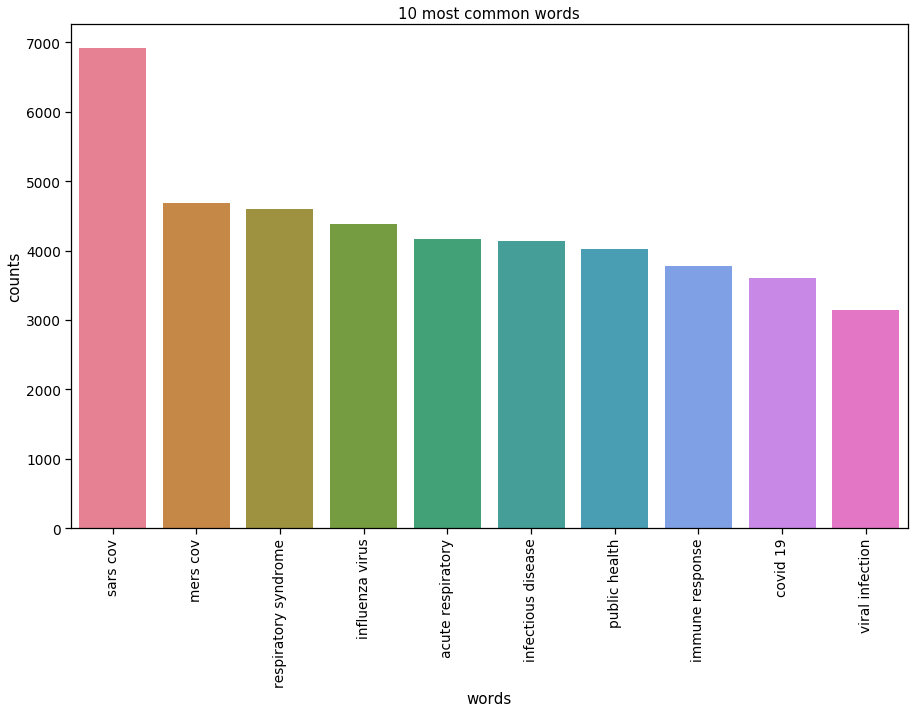

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15 / 1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [26]:
number_topics = 12
number_words = 10



# Run LDA
lda = LatentDirichletAllocation(n_components=number_topics, max_iter=100,random_state=0,n_jobs=-1)
lda.fit(count_data)
lda_data = pd.DataFrame(lda.transform(count_data), columns = ["Topic_"+str(i) for i in range(number_topics)])
agg_df = pd.concat([df,lda_data], axis=1)

aggregations = {"Topic_"+str(i):'mean' for i in range(number_topics)}
aggregations["url"] = "count"
agg_df = agg_df.groupby("publish_year").agg(aggregations)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
immune response, cd8 cell, cd4 cell, il 10, cell response, central nervous, dendritic cell, peripheral blood, inflammatory response, mouse model

Topic #1:
viral infection, gene expression, innate immune, immune response, cell line, infected cell, host cell, viral replication, virus infection, signaling pathway

Topic #2:
respiratory virus, respiratory tract, real time, rt pcr, influenza virus, respiratory infection, tract infection, chain reaction, respiratory syncytial, polymerase chain

Topic #3:
covid 19, 2019 ncov, novel coronavirus, intensive care, care unit, coronavirus disease, confirmed case, december 2019, february 2020, disease 2019

Topic #4:
influenza virus, immune response, avian influenza, neutralizing antibody, infectious disease, public health, virus infection, ebola virus, dna vaccine, antibody response

Topic #5:
mers cov, middle east, respiratory syndrome, east respiratory, syndrome coronavirus, coronavirus mers, cov infection, saudi

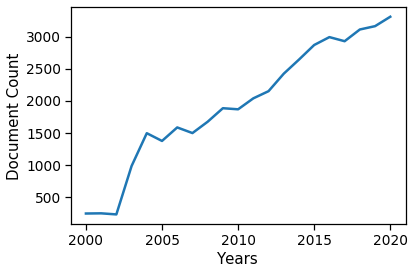

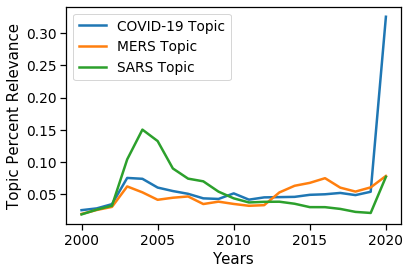

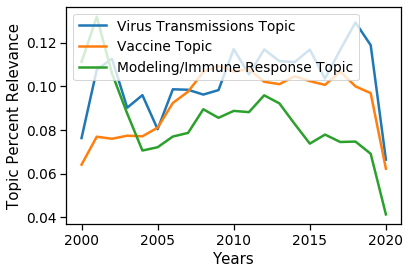

In [27]:
plt.figure()
plt.plot(agg_df["url"])
plt.xlabel('Years')
plt.ylabel('Document Count')


plt.figure()
plt.plot(agg_df["Topic_3"], label="COVID-19 Topic")
plt.plot(agg_df["Topic_5"], label="MERS Topic")
plt.plot(agg_df["Topic_6"], label="SARS Topic")
plt.xlabel('Years')
plt.ylabel('Topic Percent Relevance')
plt.legend(loc='upper left')

plt.figure()
plt.plot(agg_df["Topic_2"], label="Virus Transmissions Topic")
plt.plot(agg_df["Topic_4"], label="Vaccine Topic")
plt.plot(agg_df["Topic_0"], label="Modeling/Immune Response Topic")
plt.xlabel('Years')
plt.ylabel('Topic Percent Relevance')
plt.legend(loc='upper left')

In [28]:
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis
import os

LDAvis_data_filepath = os.path.join('./ldavis_prepared_' + str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)


C:\Users\603766\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [29]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.175366 -0.100763       1        1  13.864110
1     -0.241736 -0.041320       2        1  12.377471
10     0.202720 -0.101784       3        1  10.439891
7     -0.263018  0.035893       4        1   9.775454
4     -0.020167 -0.053765       5        1   9.175118
0     -0.125786 -0.087044       6        1   8.264406
9     -0.020411 -0.057160       7        1   8.034381
3      0.259894 -0.046478       8        1   7.898240
11     0.009380 -0.063102       9        1   5.708354
5      0.180757  0.201239      10        1   5.096661
6     -0.017533  0.366464      11        1   4.978790
8     -0.139468 -0.052179      12        1   4.387123, topic_info=      Category         Freq                    Term        Total  loglift  logprob
15972  Default  6874.000000                sars cov  6874.000000  30.0000  30.0000
10893  Default  4645.000000        

In [30]:
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_' + str(number_topics) + '.html')